#**분석 레포트 통합 분석 및 주가 예측 그리고 시각화**

Notebook 활용한 비정형의 정형화부터 ML에 의해 생성된 정형데이터의 통합 그리고 시각화까지의 단일 파이프라인

##**(1) 필요한 변수들을 선언**

In [78]:
# 코드 작성에 앞서 필요한 변수들을 설정합니다.
project_id = "pdf-bq-demo"
dataset_id = "onboard_demo"
table_id = "onboard_gen_ai_generated"
location = "us-central1"
bucket_name = "changseop-demo-pdftobq"
folder_name = "demo_source2"
gen_ai_model = "gemini-2.5-pro" # gemini-2.5-pro 는 asia-notheast3 (Seoul) 리전 지원 X

##**(2) BigQuery 테이블 스키마를 정의하고 테이블을 생성**

BigQuery는 **Google Cloud**에서 제공하는 **서버리스, 고도로 확장 가능한 엔터프라이즈 데이터 웨어하우스**입니다.
페타바이트 규모의 데이터를 SQL 쿼리로 신속하게 분석할 수 있으며, 인프라를 직접 관리할 필요가 없습니다.
대규모 데이터 분석 및 비즈니스 인텔리전스를 위해 설계되었습니다.

In [79]:
from google.cloud import bigquery

############################################
################ 테이블 생성 #################
############################################

# 클라이언트 객체 초기화
client = bigquery.Client()

# 스키마 정의
# 각 필드의 이름(name), 타입(field_type), 모드(mode)를 지정합니다.
# 모드: 'NULLABLE' (선택적), 'REQUIRED' (필수), 'REPEATED' (배열)
schema = [
    bigquery.SchemaField("Company", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("Industry", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("Analyst_Name", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("Analyst_Company", "STRING", mode="NULLABLE"),
    # Investment_Score  = 투자 의견에 대한 [긍정 | 중립 | 부정]
    bigquery.SchemaField("Investment_Score", "STRING", mode="NULLABLE"),
    # Investment_Reason = 평가 근거
    bigquery.SchemaField("Investment_Reason", "STRING", mode="NULLABLE"),
    # Comments_Summary  = 총평
    bigquery.SchemaField("Comments_Summary", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("source_pdf_uri", "STRING", mode="NULLABLE"),
]

# 테이블 객체 생성
table_ref = client.dataset(dataset_id).table(table_id)
table = bigquery.Table(table_ref, schema=schema)

# 테이블 존재유무 확인 후 존재한다면 삭제하고 생성
try:
   client.get_table(table)
   print(f"테이블 {table}을 발견했습니다. 삭제를 진행합니다.")

   client.delete_table(table)
   print(f"테이블 {table}을 삭제했습니다.")

   table = client.create_table(table)
   print(f"테이블 {table}을 생성했습니다.")
except Exception as e:
  print(f"테이블 생성 중 오류 발생 : {e}")


테이블 pdf-bq-demo.onboard_demo.onboard_gen_ai_generated을 발견했습니다. 삭제를 진행합니다.
테이블 pdf-bq-demo.onboard_demo.onboard_gen_ai_generated을 삭제했습니다.
테이블 pdf-bq-demo.onboard_demo.onboard_gen_ai_generated을 생성했습니다.


In [80]:
from google.cloud import storage

##################################################################
#################### 버킷으로부터 파일 리스트 획득 #####################
##################################################################

def list_uris(bucket_name, folder_name, file_name_endswith):
    storage_client = storage.Client()
    blobs = storage_client.list_blobs(
        bucket_name,
        prefix=folder_name
    )

    uris = []
    for blob in blobs:
        if blob.name.lower().endswith(file_name_endswith):
            uris.append(f"gs://{bucket_name}/{blob.name}")
    #print(uris)
    return uris

In [81]:
uris = list_uris(bucket_name, folder_name, '.pdf')
for uri in uris:
  print(uri)

gs://changseop-demo-pdftobq/demo_source2/AegisTech-report.pdf
gs://changseop-demo-pdftobq/demo_source2/Changtech-report.pdf
gs://changseop-demo-pdftobq/demo_source2/HyperChip-report.pdf
gs://changseop-demo-pdftobq/demo_source2/QuantumDynamics-report.pdf


In [82]:
import json
import vertexai
import vertexai.preview.generative_models as generative_models
from vertexai.generative_models import GenerativeModel, Part, SafetySetting, FinishReason

#####################################################################
################ Gen AI를 이용해 PDF로부터 필요한 데이터 추출 ##############
#####################################################################

def generate(pdf_uri, prompt, generation_config, safety_settings):
   vertexai.init(project=project_id, location=location)
   model = GenerativeModel(gen_ai_model)

   print(f"처리 중인 PDF : {pdf_uri}")
   pdf_part = Part.from_uri(
      uri=pdf_uri,
      mime_type="application/pdf" #MIME 타입으로 pdf 지정
   )

   responses = model.generate_content(
      [pdf_part, prompt],
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True
   )

   all_text_chunks = []

   for response in responses:
      all_text_chunks.append(response.text)
      combined_text= ''.join(all_text_chunks)


   try:
      if combined_text.startswith("```json") and combined_text.endswith("```"):
         combined_text=combined_text[7:-3]
         print(f"테이블 구성위해 결합한 데이터 : \n {combined_text}")

      data= json.loads(combined_text)
      return data

   except json.JSONDecodeError as e:
      print(f"JSON 디코딩 에러: {e}")
      print(f"현재 결합된 텍스트상태: {combined_text}")
      return None

##(3) 프롬프트 작성
예) https://gemini.google.com/corp/app/2559af38247815bf

In [83]:
##################################################################
######################## 프롬프트 작성 ##############################
##################################################################


prompt = """첨부된 PDF 분석해줘 해당 PDF에서 각 분석가들이 지표를 보고 분석한(표, 그래프형태일 거야. 예를들면, 실적 테이블, 영업실적, 투자지표, 실적 추정치, 재무상태표, 현금흐름표, 포괄손익계산서와 같은 것들이 있겠지.) 수치를 근거가 뒷받침 되어야 해.

1.  **Company:** 문서에서 분석의 대상이 되는 회사 이름이며 공백없이 적어야 해.
2.  **Industry:** 회사명 산업군과 사업내용을 웹에서 검색한 다음 찾은 산업명을 근거로 아래 리스트 [Industry_List]내에서만 정확히 1개만 지정하여 채워줘. 그리고, 계열사의 관계나 특정 산업에 대한 솔루션 제공여부와 상관없이 해당 회사가 직접적으로 수행하는 '핵심사업'의 산업군으로 결정해줘. 예를 들어서, 자동차계열사여서 자동차관련소프트웨어 솔루션을 제공하면 자동차업이 아니라 전산업이라는 결론이 나와. 만약 주어진 리스트에 완전히 일치하는 산업명이 없다면 가장 유사성이 높은 것으로 1개만 선택해줘. 절대 여러개 선택하지마.
     - **[Industry_List]** : [전산업, 농림어업, 광업, 제조업, 전기가스수도, 폐수처리 및 자원재활용, 건설, 제조업, 고위기술산업군, 의약, 반도체, 디스플레이, 컴퓨터, 통신기기, 가전, 정밀기기, 전지, 항공, 중고위기술산업군, 석유화학, 정밀화학, 기타 전자부품, 전기기기, 일반목적기계, 특수목적기계, 자동차, 철도, 기타 수송장비, 중저위기술산업군, 석유정제, 고무, 플라스틱, 유리, 세라믹, 시멘트, 기타 비금속 광물, 철강, 비철금속, 주조, 조립금속, 조선, 저위기술산업군, 음식료, 담배, 섬유, 의류, 가죽·신발, 목재, 제지, 인쇄, 가구, 기타 제조업, 서비스업, 유통서비스, 도·소매업, 운수·보관, 생산자서비스, 출판, 방송, 통신, 정보, 금융·보험, 부동산, 임대, 전문·과학기술, 사업시설관리서비스, 사업지원, 사회서비스, 공공교육, 교육, 의료·보건, 사회복지, 개인서비스, 숙박·음식점, 예술·스포츠·여가, 기타 서비스]
3.  **Analyst Name:** 분석가의 이름이야. 문서를 작성한 사람이기도 해. 만약 이름이 불분명하다면 "익명의 분석가"로 나타내줘.
4.  **Analyst Company:** 분석가의 회사이름이고 공백없이 적고 영어는 대문자로 채워줘. 만약 회사가 불분명하다면 "익명 회사"로 나타내줘.
     - 예를 들어서 창섭증권 리서치센터 이렇게 정리되는 경우 창섭증권으로 정리해줘. 회사명은 정확하게 회사명만 들어가야해.
5.  **Investment_Score:** 분석가의 분석내용과 근거를 전반적으로 살펴보고 분석가가 투자에 대한 생각이 어떤지 "긍정", "중립", "부정" 중 하나로만 정리해줘. 보통, 문서 내에도 Buy(유지), 중립(하향) 식으로 되어있다면 이런 지표와 매치어야 해.
     - 분류할 때 분명한 근거를 바탕으로 신중을 기하고, 아주 약간의 부정성이나 긍정성이라도 있다면 부정 또는 긍정으로 분류하세요.
     - 목표주가는 증권사 애널리스트들이 특정 주식이 향후 6개월에서 1년 이내에 도달할 것으로 예상하는 주가를 의미합니다. 이는 기업의 재무 상태, 산업 동향, 시장 상황 등을 분석하여 산출한다고하는데 목표주가가 근거될 수 있을 것 같아.
6.  **Investment_Reason:** 분석가가 5번에서 '긍정', '부정', '중립'을 판단한 근거를 적는 곳이야. 분석가는 수치적인 데이터를 근거했을 것이고 이를 바탕으로 3문장 이내로 요약해줘. 예시) A사의 6개월 간 영업이익을 보면 3%씩 우상향했으며 A사의 큰 세미나가 열린 8월에는 5%가 성장한 이익을 만들어냈습니다. 또한, 해당 산업군인 반도체 산업군은 향후 긍정적일 것으로 예상되기 때문입니다.
     - 만약 분석가가 '반도체 산업군의 미래가 밝아서 긍정적이기도 하다.' 라는 식으로 문서 데이터로 근거를 확인하기 어려운 내용은 검색해서 뉴스 기사같이 신뢰성 있는 미디어 자료만 참고하여 근거를 적어도 돼 다만, 이때는 **제미나이가 추가로 찾은 근거**라는 표시가 들어간 뒤에 문장을 추가해줘.
7.  **Comments_Summary** 해당 기업은 어떻게 전망되고 있는지 총평을 한 문장으로 요약해줘.




**출력 형식:**
결과는 JSON 리스트 형태로만 반환하세요. JSON 리스트 앞뒤에 어떤 텍스트도 포함하지 마세요. JSON은 다음 구조를 정확히 따라야 합니다:
Company와 Analyst Company는 영문인 경우 영문 유지하세요. 국문인 경우만 국문으로 유지합니다.
그리고 Analyst Name의 결과는 한국식 이름일 경우 영어더라도 한글로 출력하세요. 영문은 First name + Last name 구조지만 한글은 Last name + First name 구조입니다. 맞춰서 출력하세요.

```json
[
  {
    "Company": "구글코리아",
    "Industry": "전산업",
    "Analyst_Name": "신창섭",
    "Analyst_Company": "창섭투자증권",
    "Investment_Score": "긍정",
    "Investment_Reason": "구글의 지난 3년 간의 영업순이익을 살펴보면 약 5%가 성장한 것을 볼 수 있습니다. 중간의 2% 하락한 시기가 있지만 경쟁사의 신제품 출시로 인한 하락으로 보여지며 대응할 수 있는 구글의 솔루션 제시로 빠르게 회복했다는 것이 그 시점에서 3개월 간의 지표가 근거됩니다. 또한, AI시대에 따라 최근 Gemini 2.5 벤치마킹의 우수성이 입증되어 회사의 성장이 지속될 것으로 보입니다.",
    "Comments_Summary": "최근 한국에서 개최한 구글클라우드데이의 성공적인 개최 및 Gemini 2.5의 성공은 AI시대에서 구글의 성장은 긍정적일 수 밖에 없습니다."
  },
  {
    "Company": "햄버거사랑",
    "Industry": "숙박·음식점"
    "Analyst Name": "김치킨",
    "Analyst Company": "치킨투자증권",
    "Investment_Score": "긍정",
    "Investment_Reason": "햄버거사랑의 최근 피자좋아해요밴드와 콜라보레이션한 제품이 성공적으로 출시되어 판매량이 급증했습니다. 기존의 인지도가 낮던 상황을 글로벌 인지도를 가진 밴드와 협업하면서 글로벌 팬들에게도 이름을 알린 것이 크며 실제로 지난 3분기 간의 영업이익이 꾸준히 오르고 있었기 때문입니다. 대표의 사생활이 대중들에게 브랜드가 조금 부정적인 이미지를 가질 수 있도록 하는 요소긴 하지만 맛과 마케팅의 우수성으로 아직은 성장가능성이 더 긍정적입니다.",
    "Comments_Summary": "피자좋아해요밴드와 콜라보레이션한 제품과 일정금액 구매 이상시 제공하는 굿즈의 인기가 가히 폭발적이고 영업실적이 전달과 비교했을때 10% 향상되었으며 젊은 10-10대를 타겟한 다양한 팝업스토어와 같은 이벤트 성 행사가 성공적으로 이뤄지고 있습니다."
  }
]"""

generation_config = {
    "max_output_tokens": 8192, # 모델이 생성할 수 있는 최대 출력 토큰(단어 또는 단어 조각) 수
    "temperature": 1,          # 모델의 창의성과 무작위성 (1=창의적, 0=예측가능, 일관된)
    "top_p": 0.95,             # 확률 기반의 누적 샘플링
}

safety_settings = [
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category=SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold=SafetySetting.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
]

In [84]:
##################################################################
################# BigQuery 에 JSON 데이터 로드  #####################
##################################################################

def load_to_bigquery(data, table):

  try:
    client = bigquery.Client()
    table_id = table
    job_config = bigquery.LoadJobConfig(
      schema = [
        bigquery.SchemaField("Company", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Industry", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Analyst_Name", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Analyst_Company", "STRING", mode="NULLABLE"),
        bigquery.SchemaField("Investment_Score", "STRING", mode="NULLABLE"),   # 투자의견에 긍정, 중립, 부정
        bigquery.SchemaField("Investment_Reason", "STRING", mode="NULLABLE"),  # 평가 근거
        bigquery.SchemaField("Comments_Summary", "STRING", mode="NULLABLE"),   #총평
        bigquery.SchemaField("source_pdf_uri", "STRING", mode="NULLABLE"),
      ],

      source_format=bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
      write_disposition="WRITE_APPEND",
      # write 작업 재시도시 중복성 특성상 문제가 생기므로 테이블 삭제 과정 후 재구성이 필요
      # 즉, 해당 작업 오류시 처음 작업부터 다시 진행 필요
      )
    #빅쿼리에 데이터 로드
    job = client.load_table_from_json(data, table_id, job_config=job_config)
    job.result()  # job이 완성되도록 대기

  except Exception as e:
    print(f"빅쿼리로 데이터 로드 중 에러 발생: {e}")

##(4) Gen AI에 프롬프트를 입력하여 얻은 결과를 BigQuery 에 저장

In [85]:
####################### 실행 ##########################

pdf_uris = list_uris(bucket_name, folder_name, '.pdf')
# 모든 PDF 파일 반복작업:
for pdf_uri in pdf_uris:
  data = generate(pdf_uri, prompt, generation_config, safety_settings)
  if data: # 데이터가 성공적으로 생성되었는지 확인 후 BigQuery에 로드
    load_to_bigquery(data, table)

/usr/local/lib/python3.11/dist-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


처리 중인 PDF : gs://changseop-demo-pdftobq/demo_source2/AegisTech-report.pdf
테이블 구성위해 결합한 데이터 : 
 
[
  {
    "Company": "Aegis Tech",
    "Industry": "반도체",
    "Analyst_Name": "김하은",
    "Analyst_Company": "BLUE WAVE ASSET",
    "Investment_Score": "중립",
    "Investment_Reason": "투자의견 'HOLD'는 향후 12개월 목표주가까지의 상승 여력이 +11.8%로 제한적이기 때문입니다. 2025년 2분기 영업이익이 컨센서스를 상회할 것으로 예상되는 등 펀더멘털은 견고하지만, 이러한 단기 호재는 이미 주가에 반영되었다고 판단됩니다. 따라서 2026년부터 본격적인 매출 발생이 기대되는 고마진 '아틀라스' 프로젝트의 성과가 가시화되어야 의미있는 주가 상승이 가능할 것입니다.",
    "Comments_Summary": "핵심 메모리 모듈 사업이 안정화되고 있으나, 단기적인 주가 상승 촉매제가 이미 주가에 반영되어 상승 여력이 제한적이며, 장기적인 성장은 '아틀라스' 프로젝트의 성공에 달려있습니다."
  }
]

처리 중인 PDF : gs://changseop-demo-pdftobq/demo_source2/Changtech-report.pdf
테이블 구성위해 결합한 데이터 : 
 
[
  {
    "Company": "Chang Tech",
    "Industry": "기타 전자부품",
    "Analyst_Name": "김민준",
    "Analyst_Company": "GEMINI SECURITIES",
    "Investment_Score": "긍정",
    "Investment_Reason": "2025년 2분기 예상 영업이익이 126억 원으로 시장 컨센서스에 부합할 것으로 전망되며, 이는 신규 모델의 힌지 평균판매단가(ASP)가 약 30%

##(5) ARIMA_PLUS 모델 트레이닝 수행

In [86]:
# 모델훈련 - Model training

# f-string (f"")을 사용하여 SQL 쿼리 문자열 생성
query_string = f"""
CREATE OR REPLACE MODEL
  `{project_id}.{dataset_id}.tab_2_stock_arima_model`
OPTIONS
  (
    model_type = 'ARIMA_PLUS',
    time_series_timestamp_col = 'Date',
    time_series_data_col = 'ClosingPrice',
    time_series_id_col = 'Company',
    data_frequency = 'DAILY'
  ) AS
SELECT
  Company,
  Date,
  ClosingPrice
FROM
  `{project_id}.{dataset_id}.all_stock_data`
;
"""

In [87]:
%%bigquery --project $project_id
$query_string

Query is running:   0%|          |

""


ARIMA\_PLUS는 주로 **시계열 예측(Time Series Forecasting)**이 필요한 모든 분야에 사용됩니다. 특히, 과거 데이터의 패턴(추세, 계절성 등)을 분석하여 미래의 수치 값을 예측하는 데 최적화되어 있습니다.

BigQuery ML의 ARIMA\_PLUS 모델이 널리 사용되는 주요 분야는 다음과 같습니다.

---

## >> ARIMA\_PLUS의 주요 사용 분야

### 1. **비즈니스 및 금융 예측**
가장 일반적인 사용 사례이며, 특히 비즈니스 의사 결정에 직접적인 영향을 미치는 지표 예측에 유용합니다.

* **수요 예측 (Demand Forecasting):** 특정 제품이나 서비스의 미래 판매량, 웹사이트 트래픽, 사용자 가입자 수 등을 예측하여 재고 관리, 생산 계획, 마케팅 예산을 수립합니다.
* **재무 예측 (Financial Forecasting):** 주가, 환율, 원자재 가격, 회사의 현금 흐름, 분기별 매출 또는 비용 등을 예측합니다.
* **인력 관리:** 특정 시기에 필요한 고객 서비스 인력, 콜센터 응대량 등을 예측하여 인력 배치 계획을 세웁니다.

### 2. **IT 및 인프라 관리**
클라우드 리소스 및 서비스 운영의 효율성을 높이는 데 사용됩니다.

* **클라우드 자원 사용량 예측:** CPU 사용률, 메모리 사용량, 디스크 I/O 등 미래의 클라우드 인프라 사용량을 예측하여 **자동 확장(Auto-scaling)** 정책을 최적화하고 불필요한 비용 낭비를 줄입니다.
* **이상 감지 및 모니터링:** 평소와 다른 트래픽이나 지연 시간(Latency)의 급격한 변화를 예측하여 시스템 장애를 사전에 감지합니다.

### 3. **공공 및 산업 예측**

* **에너지 사용량 예측:** 시간대별, 계절별 전력 수요를 예측하여 발전소 운영 계획을 수립합니다.
* **교통량 예측:** 특정 도로의 미래 교통량을 예측하여 혼잡도를 관리하고 최적의 경로를 안내합니다.

---

## ARIMA\_PLUS가 적합한 데이터 유형

ARIMA\_PLUS는 특히 다음 조건에 해당하는 데이터에 유용합니다.

1.  **단변량 시계열 (Univariate Time Series):** 하나의 변수(예: 매출액, 온도, 주가)가 시간에 따라 변화하는 데이터를 분석할 때 적합합니다.
2.  **명확한 패턴:** 데이터에 **추세(Trend)**나 **계절성(Seasonality)**과 같은 명확한 패턴이 있을 때 강력한 예측 능력을 발휘합니다.
3.  **데이터 품질 자동화:** 결측치나 이상치 처리를 자동으로 수행하므로, 데이터 전처리에 많은 시간을 투자하기 어려운 환경에서 특히 유용합니다.

In [88]:
# 훈련결과 - Training Result

query_string = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{project_id}.{dataset_id}.tab_2_stock_arima_model`);
"""

In [89]:
%%bigquery --project $project_id
$query_string

Query is running:   0%|          |

Downloading:   0%|          |

,Company,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes
0,1545,1,1,1,False,-4830.485375,9666.970750,3.394904e+04,[WEEKLY],False,True,False
1,1618,0,1,0,False,-6438.453902,12878.907804,2.814185e+06,[WEEKLY],False,True,True
2,1645,2,1,0,False,-4899.602872,9805.205743,4.104820e+04,[WEEKLY],False,False,False
3,1714,1,1,1,True,-7154.588452,14317.176904,2.012672e+07,[WEEKLY],False,True,True


##(6) 각 회사별 7일, 90일, 180일 뒤 예측 주가 및 테이블 생성

In [97]:
# 각 회사별 7일, 90일, 180일 뒤 예측 주가 및 테이블 생성
# 순수 예측 결과 (예측 결과)
query_string = f"""
CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.tab_3_prediction_result`
AS
SELECT
  CASE Company
       WHEN 1545 THEN 'Aegis Tech'
       WHEN 1618 THEN 'Quantum Dynamics'
       WHEN 1645 THEN 'Chang Tech'
       ELSE 'Hyper Chip'
  END AS Company,
  DATE(forecast_timestamp) AS Date,
  CAST(ROUND(prediction_interval_upper_bound) AS INT64) AS Prediction_interval_upper_bound,
  CAST(ROUND(forecast_value) AS INT64) AS Forecast_value,
  CAST(ROUND(prediction_interval_lower_bound) AS INT64) AS Prediction_interval_lower_bound
FROM
  ML.FORECAST(
    MODEL `{project_id}.{dataset_id}.tab_2_stock_arima_model`,
    STRUCT(300 AS horizon,
           0.95 AS confidence_level
    )
  )
WHERE
  forecast_timestamp IN (
    CAST(DATE_ADD(CURRENT_DATE(), INTERVAL 7 DAY) AS TIMESTAMP),
    CAST(DATE_ADD(CURRENT_DATE(), INTERVAL 90 DAY) AS TIMESTAMP),
    CAST(DATE_ADD(CURRENT_DATE(), INTERVAL 180 DAY) AS TIMESTAMP)
  )
ORDER BY
  1, 2
;
"""

In [98]:
%%bigquery --project {project_id}
$query_string

Query is running:   0%|          |

""


In [109]:
# 각 회사별 7일, 90일, 180일 뒤 예측 주가 및 테이블 생성
# 최종 분석 보고서 (예측 결과 + PDF 데이터 + 분석 의견)
query_string = f"""
CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.tab_4_final_result`
AS(
WITH unpivotTable AS (
  SELECT
    Company,
    MAX(CASE WHEN Date = DATE_ADD(CURRENT_DATE(), INTERVAL 7 DAY) THEN Prediction_interval_upper_bound END) AS predict_7,
    MAX(CASE WHEN Date = DATE_ADD(CURRENT_DATE(), INTERVAL 90 DAY) THEN Prediction_interval_upper_bound END) AS predict_90,
    MAX(CASE WHEN Date = DATE_ADD(CURRENT_DATE(), INTERVAL 180 DAY) THEN Prediction_interval_upper_bound END) AS predict_180,
  FROM
    `{project_id}.{dataset_id}.tab_3_prediction_result`
  GROUP BY
    Company
)

SELECT
  t1.* EXCEPT(source_pdf_uri),
  t3.ClosingPrice as CurrentPrice,
  t2.* EXCEPT(Company)
FROM
  `{table}` AS t1
JOIN
  unpivotTable AS t2
ON
  t1.Company = t2.Company
JOIN
  (SELECT
    CASE Company
      WHEN 1545 THEN 'Aegis Tech'
      WHEN 1618 THEN 'Quantum Dynamics'
      WHEN 1645 THEN 'Chang Tech'
      ELSE 'Hyper Chip'
    END AS Company,
    ClosingPrice
  FROM
    `{project_id}.{dataset_id}.all_stock_data`
  WHERE
    Date = '2025-07-21'
  ) as t3
ON t1.Company = t3.Company
#WHERE
  #t1.Investment_Score = '긍정'
)
;
"""

In [110]:
%%bigquery --project $project_id
$query_string

Query is running:   0%|          |

""


In [111]:
# 최종 분석 보고서 조회

query_string = f"""
SELECT DISTINCT *
FROM {project_id}.{dataset_id}.tab_4_final_result
"""

In [112]:
%%bigquery --project $project_id
$query_string

Query is running:   0%|          |

Downloading:   0%|          |

,Company,Industry,Analyst_Name,Analyst_Company,Investment_Score,Investment_Reason,Comments_Summary,CurrentPrice,predict_7,predict_90,predict_180
0,Aegis Tech,반도체,김하은,BLUE WAVE ASSET,중립,투자의견 'HOLD'는 향후 12개월 목표주가까지의 상승 여력이 +11.8%로 제한...,"핵심 메모리 모듈 사업이 안정화되고 있으나, 단기적인 주가 상승 촉매제가 이미 주가...",13130,17749,19797,21347
1,Hyper Chip,반도체,이도현,ALPHA INVESTMENT,긍정,분석가는 Hyper Chip의 2025년 연간 영업이익(OP) 전망치를 기존 대비 ...,"AI 시장 성장에 따른 첨단 패키징 수요 증가로 핵심 공급업체로 자리매김했으며, 이...",425000,534161,613494,680769
2,Quantum Dynamics,반도체,박준,GLOBAL RESEARCH,긍정,2025년 2분기 예상 영업이익은 전년 동기 대비 60% 증가한 350억 원으로 시...,AI 산업의 고성능 메모리 및 패키징 솔루션 수요에 힘입어 2026년까지 지속적인 ...,92200,119379,133218,142570
3,Chang Tech,기타 전자부품,김민준,GEMINI SECURITIES,긍정,2025년 2분기 예상 영업이익이 126억 원으로 시장 컨센서스에 부합할 것으로 전...,신규 폴더블 제품 출시 및 힌지 평균판매단가(ASP) 상승에 힘입어 실적이 시장 기...,17540,21624,23846,25675


##(7) 데이터 시각화

Investment_Score
Positive    3
Neutral     1
Negative    0
Name: count, dtype: int64


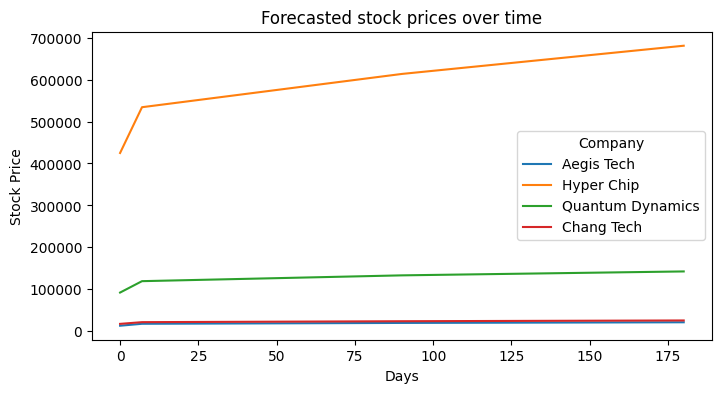

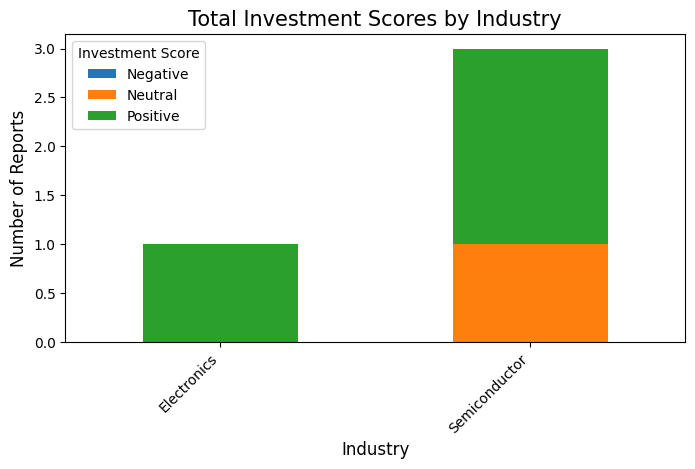

In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

table_final_result = f"{project_id}.{dataset_id}.tab_4_final_result"

sentiment_order = ["Negative", "Neutral", "Positive"]
color_map = {
    "Negative": "#FF6347",  # Tomato Red
    "Neutral": "#FFD700",   # Gold Yellow
    "Positive": "#3CB371"   # MediumSeaGreen
}

try:
    client = bigquery.Client(project=project_id)

    query = f"""
        SELECT
            Company,
            Industry,
            Analyst_Name,
            Analyst_Company,
            CASE Investment_Score
                WHEN '부정' THEN 'Negative'
                WHEN '긍정' THEN 'Positive'
                WHEN '중립' THEN 'Neutral'
                ELSE Investment_Score
            END AS Investment_Score,
            CurrentPrice,
            predict_7,
            predict_90,
            predict_180
        FROM
            `{table_final_result}`
        WHERE
            Investment_Score IN ('부정', '중립', '긍정');
    """

    df = client.query(query).to_dataframe()

    #1. 긍정, 중립, 부정 갯수
    df['Investment_Score'] = pd.Categorical(
      df['Investment_Score'],
      categories=sentiment_order,
      ordered=True
    )
    print(df['Investment_Score'].value_counts())

    #2. 회사별 주식 가격 추이 예측
    price_df = df[
      [
        'Company',
        'CurrentPrice',
        'predict_7',
        'predict_90',
        'predict_180'
      ]
    ]
    price_df = price_df.melt(
      id_vars='Company',
      var_name='Day',
      value_name='Price'
    )

    price_df['Day'] = price_df['Day'].str.extract('(\d+)').fillna(0).astype(int)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=price_df, x='Day', y='Price', hue='Company')
    plt.title('Forecasted stock prices over time')
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.legend(title='Company')
    plt.show()

    #3. 산업군별 긍정, 중립, 부정 지표
    df_en = df.copy()
    df_en['Industry'] = df_en['Industry'].replace({
        '기타 전자부품': 'Electronics',
        '운수·보관': 'Logistics',
        '조선': 'Shipbuilding',
        '도·소매업': 'Retail',
        '유통서비스': 'Retail',
        '반도체': 'Semiconductor'
    })

    industry_investment_en = df_en.groupby(['Industry', 'Investment_Score'], observed=False).size().unstack(fill_value=0)
    industry_investment_en.plot(kind='bar', stacked=True, figsize=(8, 4))
    plt.title('Total Investment Scores by Industry', fontsize=15)
    plt.xlabel('Industry', fontsize=12)
    plt.ylabel('Number of Reports', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Investment Score')
    plt.show()

except Exception as e:
    print(f"BigQuery 쿼리 실행 또는 데이터 처리 중 오류 발생: {e}")
    print("BigQuery 프로젝트 ID, 데이터셋 ID, 테이블 이름이 올바르게 설정되었는지 확인해주세요.")